# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import pimmslearn
import pimmslearn.analyzers
import pimmslearn.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
pimmslearn.plotting.make_large_descriptors(fontsize)


logger = pimmslearn.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "QRILC"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = pimmslearn.nb.get_params(args, globals=globals())
args = pimmslearn.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = pimmslearn.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'QRILC',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = pimmslearn.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

pimmslearn.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


pimmslearn.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


pimmslearn.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups 
Sample_058  O95206;O95206-2   16.774
Sample_127  I3L145;P04278     15.800
Sample_137  Q96S96            19.334
Sample_001  O14773            17.869
Sample_090  O15230            14.427
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = pimmslearn.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[pimmslearn.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = pimmslearn.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by QRILC: runs/alzheimer_study/preds/pred_real_na_QRILC.csv


Sample ID   protein groups        
Sample_149  Q5R3F8                   12.417
Sample_152  P01912;Q5Y7A7            14.884
Sample_055  C9JKT8;Q9UEW3;Q9UEW3-2   14.937
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.193
            A0A075B6Q5                 11.641
            A0A075B6R2                 13.307
            A0A075B6S5                 14.731
            A0A087WSY4                 11.595
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   13.565
            Q9UI40;Q9UI40-2            12.643
            Q9UIW2                     11.752
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.176
            Q9UP79                     12.585
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,12.619,15.050,16.842,19.863,12.985,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,13.843,19.067,...,15.528,15.576,11.000,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,14.157,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,10.296,17.705,17.039,14.751,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,10.100,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,12.737,15.345,17.084,18.708,14.249,19.433,8.808,8.748
Sample_207,15.739,16.877,15.469,16.898,13.558,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.193,...,16.012,15.178,13.188,15.050,16.842,19.863,12.398,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.607,19.067,16.188,...,15.528,15.576,13.436,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.159,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.837,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,12.755,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,11.718,15.345,17.084,18.708,14.249,19.433,12.215,11.881
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 438.73it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.06it/s]

100%|██████████| 2/2 [00:00<00:00,  4.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.43it/s]

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

100%|██████████| 3/3 [00:00<00:00,  3.98it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.87it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.98it/s]

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]

100%|██████████| 4/4 [00:01<00:00,  2.79it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.44it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.37it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.07it/s]

100%|██████████| 5/5 [00:02<00:00,  2.04it/s]

100%|██████████| 5/5 [00:02<00:00,  2.19it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.14it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.52it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  3.12it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.95it/s]

100%|██████████| 6/6 [00:01<00:00,  3.03it/s]

100%|██████████| 6/6 [00:01<00:00,  3.21it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:00,  5.27it/s]

 43%|████▎     | 3/7 [00:00<00:01,  3.44it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.94it/s]

 71%|███████▏  | 5/7 [00:01<00:00,  2.66it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.46it/s]

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]

100%|██████████| 7/7 [00:02<00:00,  2.80it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.57it/s]

 38%|███▊      | 3/8 [00:00<00:01,  4.00it/s]

 50%|█████     | 4/8 [00:01<00:01,  3.74it/s]

 62%|██████▎   | 5/8 [00:01<00:00,  3.51it/s]

 75%|███████▌  | 6/8 [00:01<00:00,  2.86it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.52it/s]

100%|██████████| 8/8 [00:02<00:00,  2.40it/s]

100%|██████████| 8/8 [00:02<00:00,  2.85it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.47it/s]

 33%|███▎      | 3/9 [00:00<00:01,  3.21it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.77it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.67it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.72it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.41it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.10it/s]

100%|██████████| 9/9 [00:03<00:00,  2.01it/s]

100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.65it/s]

 30%|███       | 3/10 [00:01<00:03,  2.32it/s]

 40%|████      | 4/10 [00:01<00:03,  1.97it/s]

 50%|█████     | 5/10 [00:02<00:02,  1.84it/s]

 60%|██████    | 6/10 [00:03<00:02,  1.81it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.93it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.01it/s]

 90%|█████████ | 9/10 [00:04<00:00,  2.13it/s]

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

100%|██████████| 10/10 [00:04<00:00,  2.14it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.83it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.68it/s]

 36%|███▋      | 4/11 [00:01<00:02,  3.00it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.89it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.93it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  3.05it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.16it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  2.75it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.62it/s]

100%|██████████| 11/11 [00:03<00:00,  2.42it/s]

100%|██████████| 11/11 [00:03<00:00,  2.84it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  6.36it/s]

 25%|██▌       | 3/12 [00:00<00:01,  4.75it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.94it/s]

 42%|████▏     | 5/12 [00:01<00:02,  2.46it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.24it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.19it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.47it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.64it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.67it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.63it/s]

100%|██████████| 12/12 [00:04<00:00,  2.45it/s]

100%|██████████| 12/12 [00:04<00:00,  2.65it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  3.97it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.57it/s]

 31%|███       | 4/13 [00:01<00:02,  3.27it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.93it/s]

 46%|████▌     | 6/13 [00:01<00:02,  3.00it/s]

 54%|█████▍    | 7/13 [00:02<00:01,  3.08it/s]

 62%|██████▏   | 8/13 [00:02<00:01,  2.71it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.34it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  1.95it/s]

 85%|████████▍ | 11/13 [00:04<00:01,  1.83it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  1.78it/s]

100%|██████████| 13/13 [00:05<00:00,  1.75it/s]

100%|██████████| 13/13 [00:05<00:00,  2.26it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.91it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.90it/s]

 29%|██▊       | 4/14 [00:01<00:03,  2.60it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.32it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.19it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.94it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.90it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.89it/s]

 71%|███████▏  | 10/14 [00:04<00:02,  1.87it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.90it/s]

 86%|████████▌ | 12/14 [00:05<00:00,  2.02it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.26it/s]

100%|██████████| 14/14 [00:06<00:00,  2.32it/s]

100%|██████████| 14/14 [00:06<00:00,  2.22it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:03,  3.56it/s]

 20%|██        | 3/15 [00:01<00:04,  2.55it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.27it/s]

 33%|███▎      | 5/15 [00:02<00:04,  2.07it/s]

 40%|████      | 6/15 [00:02<00:04,  1.95it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.87it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.83it/s]

 60%|██████    | 9/15 [00:04<00:03,  1.87it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.94it/s]

 73%|███████▎  | 11/15 [00:05<00:01,  2.14it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.35it/s]

 87%|████████▋ | 13/15 [00:06<00:00,  2.36it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.36it/s]

100%|██████████| 15/15 [00:06<00:00,  2.39it/s]

100%|██████████| 15/15 [00:06<00:00,  2.19it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.054 0.016          0.608 0.434       0.084   
2             0.007 0.008      0.079 0.035          0.716 0.088       0.600   
3             0.005 0.003      0.079 0.032          0.709 0.098       0.594   
4             0.005 0.003      0.060 0.027          0.761 0.105       0.618   
5             0.006 0.005      0.088 0.041          0.746 0.087       0.629   
6             0.009 0.008      0.091 0.038          0.772 0.092       0.764   
7             0.004 0.002      0.053 0.014          0.785 0.091       0.777   
8             0.007 0.007      0.084 0.033          0.782 0.088       0.800   
9             0.007 0.006      0.075 0.030          0.784 0.088       0.804   
10            0.006 0.005      0.068 0.029          0.795 0.096       0.788   
11            0.008 0.008      0.089 0.037          0.809 0.090       0.795   
12            0.008 0.007      0.092 0.033          0.802 0.090       0.795   
13            0.007 0.005      0.078 0.031          0.793 0.097       0.780   
14            0.006 0.005      0.073 0.029          0.790 0.091       0.782   
15            0.007 0.005      0.075 0.029          0.818 0.094       0.795   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.081   0.142 0.125                  0.535 0.038        0.845   
2          0.103   0.647 0.079                  0.711 0.057        0.777   
3          0.104   0.640 0.080                  0.705 0.059        0.771   
4          0.117   0.675 0.092                  0.736 0.066        0.783   
5          0.113   0.677 0.084                  0.735 0.060        0.779   
6          0.114   0.762 0.081                  0.798 0.068        0.881   
7          0.107   0.776 0.075                  0.809 0.063        0.879   
8          0.115   0.786 0.082                  0.817 0.069        0.898   
9          0.111   0.789 0.077                  0.819 0.066        0.897   
10         0.119   0.786 0.086                  0.818 0.072        0.894   
11         0.096   0.797 0.069                  0.827 0.058        0.907   
12         0.096   0.794 0.071                  0.824 0.060        0.905   
13         0.101   0.781 0.074                  0.813 0.063        0.902   
14         0.102   0.781 0.073                  0.813 0.061        0.901   
15         0.104   0.801 0.075                  0.831 0.062        0.905   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.066                  0.822 0.088        210.000 0.000  
2          0.068                  0.758 0.085        210.000 0.000  
3          0.068                  0.752 0.084        210.000 0.000  
4          0.069                  0.761 0.086        210.000 0.000  
5          0.068                  0.757 0.086        210.000 0.000  
6          0.053                  0.854 0.060        210.000 0.000  
7          0.051                  0.852 0.060        210.000 0.000  
8          0.050                  0.888 0.051        210.000 0.000  
9          0.051                  0.887 0.052        210.000 0.000  
10         0.053                  0.882 0.055        210.000 0.000  
11         0.051                  0.901 0.049        210.000 0.000  
12         0.051                  0.898 0.049        210.000 0.000  
13         0.051                  0.895 0.050        210.000 0.000  
14         0.051                  0.892 0.050        210.000 0.000  
15         0.051                  0.893 0.051 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 459.00it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  4.44it/s]

100%|██████████| 2/2 [00:00<00:00,  4.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  3.73it/s]

100%|██████████| 3/3 [00:01<00:00,  2.64it/s]

100%|██████████| 3/3 [00:01<00:00,  2.79it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  4.95it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  2.90it/s]

100%|██████████| 4/4 [00:01<00:00,  1.99it/s]

100%|██████████| 4/4 [00:01<00:00,  2.31it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.06it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.22it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.30it/s]

100%|██████████| 5/5 [00:02<00:00,  2.31it/s]

100%|██████████| 5/5 [00:02<00:00,  2.36it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.87it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.82it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.49it/s]

 83%|████████▎ | 5/6 [00:01<00:00,  2.31it/s]

100%|██████████| 6/6 [00:02<00:00,  2.24it/s]

100%|██████████| 6/6 [00:02<00:00,  2.44it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  4.57it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.21it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  1.77it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.57it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.47it/s]

100%|██████████| 7/7 [00:04<00:00,  1.41it/s]

100%|██████████| 7/7 [00:04<00:00,  1.63it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.62it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.30it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.79it/s]

 62%|██████▎   | 5/8 [00:01<00:01,  2.69it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.60it/s]

 88%|████████▊ | 7/8 [00:02<00:00,  2.58it/s]

100%|██████████| 8/8 [00:02<00:00,  2.58it/s]

100%|██████████| 8/8 [00:02<00:00,  2.76it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.96it/s]

 33%|███▎      | 3/9 [00:00<00:02,  2.94it/s]

 44%|████▍     | 4/9 [00:01<00:01,  2.94it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.99it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.66it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.58it/s]

 89%|████████▉ | 8/9 [00:02<00:00,  2.67it/s]

100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.58it/s]

 30%|███       | 3/10 [00:00<00:02,  3.32it/s]

 40%|████      | 4/10 [00:01<00:02,  2.74it/s]

 50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.67it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.71it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  2.58it/s]

100%|██████████| 10/10 [00:03<00:00,  2.75it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.31it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.19it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.91it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.91it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  2.86it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.89it/s]

 73%|███████▎  | 8/11 [00:02<00:01,  2.61it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.63it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.61it/s]

100%|██████████| 11/11 [00:04<00:00,  2.32it/s]

100%|██████████| 11/11 [00:04<00:00,  2.70it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.57it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.89it/s]

 33%|███▎      | 4/12 [00:01<00:02,  3.52it/s]

 42%|████▏     | 5/12 [00:01<00:02,  3.27it/s]

 50%|█████     | 6/12 [00:01<00:01,  3.00it/s]

 58%|█████▊    | 7/12 [00:02<00:01,  2.62it/s]

 67%|██████▋   | 8/12 [00:02<00:01,  2.60it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.55it/s]

 83%|████████▎ | 10/12 [00:03<00:00,  2.44it/s]

 92%|█████████▏| 11/12 [00:03<00:00,  2.39it/s]

100%|██████████| 12/12 [00:04<00:00,  2.40it/s]

100%|██████████| 12/12 [00:04<00:00,  2.73it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:02,  5.18it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.62it/s]

 31%|███       | 4/13 [00:01<00:02,  3.25it/s]

 38%|███▊      | 5/13 [00:01<00:02,  2.86it/s]

 46%|████▌     | 6/13 [00:01<00:02,  2.70it/s]

 54%|█████▍    | 7/13 [00:02<00:02,  2.72it/s]

 62%|██████▏   | 8/13 [00:02<00:02,  2.46it/s]

 69%|██████▉   | 9/13 [00:03<00:01,  2.50it/s]

 77%|███████▋  | 10/13 [00:03<00:01,  2.46it/s]

 85%|████████▍ | 11/13 [00:04<00:00,  2.33it/s]

 92%|█████████▏| 12/13 [00:04<00:00,  2.37it/s]

100%|██████████| 13/13 [00:04<00:00,  2.45it/s]

100%|██████████| 13/13 [00:04<00:00,  2.65it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.34it/s]

 21%|██▏       | 3/14 [00:00<00:02,  3.82it/s]

 29%|██▊       | 4/14 [00:01<00:02,  3.41it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.80it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.52it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.22it/s]

 57%|█████▋    | 8/14 [00:02<00:02,  2.31it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.16it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.29it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.38it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.41it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.53it/s]

100%|██████████| 14/14 [00:05<00:00,  2.62it/s]

100%|██████████| 14/14 [00:05<00:00,  2.60it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.56it/s]

 20%|██        | 3/15 [00:00<00:03,  3.90it/s]

 27%|██▋       | 4/15 [00:01<00:03,  3.45it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.93it/s]

 40%|████      | 6/15 [00:02<00:03,  2.44it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.47it/s]

 53%|█████▎    | 8/15 [00:02<00:02,  2.53it/s]

 60%|██████    | 9/15 [00:03<00:02,  2.31it/s]

 67%|██████▋   | 10/15 [00:03<00:02,  2.39it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.41it/s]

 80%|████████  | 12/15 [00:04<00:01,  2.40it/s]

 87%|████████▋ | 13/15 [00:04<00:00,  2.53it/s]

 93%|█████████▎| 14/15 [00:05<00:00,  2.62it/s]

100%|██████████| 15/15 [00:05<00:00,  2.61it/s]

100%|██████████| 15/15 [00:05<00:00,  2.66it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.083 0.038          0.899 0.158       0.165   
2             0.005 0.005      0.073 0.039          0.601 0.112       0.487   
3             0.006 0.007      0.075 0.034          0.813 0.080       0.715   
4             0.006 0.006      0.085 0.037          0.806 0.082       0.764   
5             0.006 0.006      0.070 0.033          0.805 0.084       0.756   
6             0.007 0.006      0.080 0.038          0.804 0.088       0.758   
7             0.005 0.003      0.067 0.029          0.829 0.084       0.790   
8             0.005 0.002      0.057 0.021          0.827 0.084       0.790   
9             0.005 0.003      0.055 0.017          0.820 0.085       0.792   
10            0.005 0.003      0.050 0.012          0.827 0.081       0.838   
11            0.005 0.003      0.055 0.014          0.818 0.082       0.839   
12            0.004 0.000      0.053 0.020          0.815 0.081       0.838   
13            0.005 0.003      0.052 0.013          0.823 0.081       0.841   
14            0.005 0.005      0.057 0.014          0.832 0.084       0.835   
15            0.009 0.008      0.083 0.042          0.830 0.082       0.835   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.088   0.267 0.121                  0.574 0.041        0.854   
2          0.127   0.529 0.101                  0.623 0.067        0.708   
3          0.106   0.756 0.073                  0.796 0.058        0.907   
4          0.109   0.779 0.073                  0.813 0.059        0.908   
5          0.113   0.774 0.078                  0.809 0.063        0.903   
6          0.111   0.775 0.079                  0.810 0.064        0.901   
7          0.099   0.805 0.070                  0.834 0.060        0.911   
8          0.094   0.805 0.072                  0.834 0.061        0.911   
9          0.097   0.803 0.074                  0.832 0.063        0.911   
10         0.087   0.829 0.064                  0.853 0.055        0.921   
11         0.091   0.824 0.066                  0.850 0.057        0.918   
12         0.092   0.823 0.068                  0.848 0.059        0.916   
13         0.090   0.828 0.062                  0.852 0.054        0.917   
14         0.089   0.830 0.067                  0.855 0.057        0.918   
15         0.089   0.829 0.065                  0.854 0.055        0.918   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.825 0.088        210.000 0.000  
2          0.080                  0.656 0.097        210.000 0.000  
3          0.046                  0.883 0.059        210.000 0.000  
4          0.045                  0.885 0.055        210.000 0.000  
5          0.048                  0.881 0.057        210.000 0.000  
6          0.049                  0.879 0.058        210.000 0.000  
7          0.052                  0.893 0.061        210.000 0.000  
8          0.048                  0.893 0.060        210.000 0.000  
9          0.049                  0.895 0.058        210.000 0.000  
10         0.045                  0.909 0.052        210.000 0.000  
11         0.044                  0.904 0.050        210.000 0.000  
12         0.045                  0.902 0.051        210.000 0.000  
13         0.045                  0.904 0.050        210.000 0.000  
14         0.045                  0.907 0.050        210.000 0.000  
15         0.045                  0.906 0.050 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 893.17it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 17.50it/s]

100%|██████████| 2/2 [00:00<00:00, 16.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00, 11.03it/s]

100%|██████████| 3/3 [00:00<00:00,  9.66it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 19.07it/s]

100%|██████████| 4/4 [00:00<00:00, 16.87it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 14.47it/s]

100%|██████████| 5/5 [00:00<00:00, 13.09it/s]

100%|██████████| 5/5 [00:00<00:00, 13.25it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 30.87it/s]

100%|██████████| 6/6 [00:00<00:00, 25.67it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 20.38it/s]

 86%|████████▌ | 6/7 [00:00<00:00, 14.99it/s]

100%|██████████| 7/7 [00:00<00:00, 14.72it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 26.41it/s]

 75%|███████▌  | 6/8 [00:00<00:00, 18.01it/s]

100%|██████████| 8/8 [00:00<00:00, 16.81it/s]

100%|██████████| 8/8 [00:00<00:00, 17.66it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 19.73it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 15.32it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 14.96it/s]

100%|██████████| 9/9 [00:00<00:00, 14.52it/s]

100%|██████████| 9/9 [00:00<00:00, 15.04it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 16.51it/s]

 50%|█████     | 5/10 [00:00<00:00, 13.17it/s]

 70%|███████   | 7/10 [00:00<00:00, 11.77it/s]

 90%|█████████ | 9/10 [00:00<00:00, 12.35it/s]

100%|██████████| 10/10 [00:00<00:00, 12.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 15.72it/s]

 45%|████▌     | 5/11 [00:00<00:00, 13.16it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 11.45it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 10.58it/s]

100%|██████████| 11/11 [00:00<00:00, 10.19it/s]

100%|██████████| 11/11 [00:01<00:00, 10.99it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 25%|██▌       | 3/12 [00:00<00:00, 19.82it/s]

 42%|████▏     | 5/12 [00:00<00:00, 15.10it/s]

 58%|█████▊    | 7/12 [00:00<00:00, 13.63it/s]

 75%|███████▌  | 9/12 [00:00<00:00, 11.49it/s]

 92%|█████████▏| 11/12 [00:00<00:00, 10.41it/s]

100%|██████████| 12/12 [00:01<00:00, 11.43it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 22.86it/s]

 46%|████▌     | 6/13 [00:00<00:00, 15.31it/s]

 62%|██████▏   | 8/13 [00:00<00:00, 14.79it/s]

 77%|███████▋  | 10/13 [00:00<00:00, 13.72it/s]

 92%|█████████▏| 12/13 [00:00<00:00, 13.15it/s]

100%|██████████| 13/13 [00:00<00:00, 14.23it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 21%|██▏       | 3/14 [00:00<00:00, 19.63it/s]

 36%|███▌      | 5/14 [00:00<00:00, 16.01it/s]

 50%|█████     | 7/14 [00:00<00:00, 14.57it/s]

 64%|██████▍   | 9/14 [00:00<00:00, 13.77it/s]

 79%|███████▊  | 11/14 [00:00<00:00, 13.70it/s]

 93%|█████████▎| 13/14 [00:00<00:00, 14.87it/s]

100%|██████████| 14/14 [00:00<00:00, 14.42it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 20%|██        | 3/15 [00:00<00:00, 19.22it/s]

 33%|███▎      | 5/15 [00:00<00:00, 15.31it/s]

 47%|████▋     | 7/15 [00:00<00:00, 13.24it/s]

 60%|██████    | 9/15 [00:00<00:00, 12.42it/s]

 73%|███████▎  | 11/15 [00:00<00:00, 12.32it/s]

 87%|████████▋ | 13/15 [00:00<00:00, 12.62it/s]

100%|██████████| 15/15 [00:01<00:00, 12.50it/s]

100%|██████████| 15/15 [00:01<00:00, 12.99it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.005 0.004      0.069 0.029          0.490 0.467       0.045   
2             0.008 0.008      0.107 0.035          0.596 0.096       0.479   
3             0.005 0.003      0.063 0.027          0.577 0.102       0.468   
4             0.005 0.004      0.062 0.022          0.571 0.092       0.443   
5             0.003 0.002      0.043 0.016          0.578 0.102       0.459   
6             0.003 0.001      0.032 0.007          0.602 0.085       0.479   
7             0.004 0.000      0.045 0.007          0.595 0.106       0.484   
8             0.003 0.001      0.041 0.006          0.583 0.081       0.488   
9             0.006 0.006      0.067 0.023          0.577 0.083       0.483   
10            0.004 0.000      0.048 0.013          0.582 0.086       0.491   
11            0.004 0.002      0.038 0.007          0.580 0.087       0.491   
12            0.005 0.003      0.054 0.021          0.568 0.082       0.493   
13            0.005 0.003      0.060 0.018          0.567 0.077       0.492   
14            0.005 0.003      0.060 0.023          0.573 0.087       0.512   
15            0.005 0.004      0.055 0.019          0.566 0.083       0.515   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.048   0.080 0.084                  0.516 0.026        0.737   
2          0.098   0.524 0.086                  0.618 0.062        0.693   
3          0.098   0.512 0.086                  0.606 0.066        0.684   
4          0.093   0.494 0.081                  0.598 0.060        0.687   
5          0.099   0.507 0.092                  0.606 0.068        0.682   
6          0.095   0.529 0.082                  0.624 0.056        0.697   
7          0.099   0.530 0.092                  0.621 0.066        0.694   
8          0.104   0.526 0.082                  0.616 0.055        0.694   
9          0.110   0.519 0.086                  0.611 0.057        0.688   
10         0.109   0.526 0.084                  0.615 0.057        0.682   
11         0.109   0.525 0.084                  0.614 0.059        0.672   
12         0.103   0.522 0.079                  0.608 0.055        0.669   
13         0.103   0.521 0.078                  0.608 0.053        0.663   
14         0.101   0.535 0.080                  0.615 0.061        0.675   
15         0.101   0.533 0.075                  0.611 0.056        0.668   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.062                  0.679 0.076        210.000 0.000  
2          0.067                  0.638 0.083        210.000 0.000  
3          0.070                  0.627 0.086        210.000 0.000  
4          0.065                  0.629 0.076        210.000 0.000  
5          0.064                  0.627 0.073        210.000 0.000  
6          0.062                  0.646 0.068        210.000 0.000  
7          0.067                  0.644 0.068        210.000 0.000  
8          0.064                  0.641 0.066        210.000 0.000  
9          0.067                  0.636 0.069        210.000 0.000  
10         0.069                  0.632 0.073        210.000 0.000  
11         0.068                  0.631 0.075        210.000 0.000  
12         0.069                  0.631 0.075        210.000 0.000  
13         0.068                  0.625 0.072        210.000 0.000  
14         0.068                  0.627 0.074        210.000 0.000  
15         0.068                  0.621 0.076 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,6,15,2
score_time,12,4,2
test_precision,15,1,6
test_recall,9,13,15
test_f1,15,14,14
test_balanced_accuracy,15,14,6
test_roc_auc,11,10,1
test_average_precision,11,10,1
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
pimmslearn.io.to_pickle(results_ald_full, fname)

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  5.42it/s]

 30%|███       | 3/10 [00:00<00:01,  3.85it/s]

 40%|████      | 4/10 [00:01<00:01,  3.42it/s]

 50%|█████     | 5/10 [00:01<00:01,  3.05it/s]

 60%|██████    | 6/10 [00:01<00:01,  2.96it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.93it/s]

 80%|████████  | 8/10 [00:02<00:00,  2.79it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.45it/s]

100%|██████████| 10/10 [00:03<00:00,  2.20it/s]

100%|██████████| 10/10 [00:03<00:00,  2.74it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 1079.89it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  6.70it/s]

 27%|██▋       | 3/11 [00:00<00:01,  4.32it/s]

 36%|███▋      | 4/11 [00:00<00:01,  4.02it/s]

 45%|████▌     | 5/11 [00:01<00:01,  3.59it/s]

 55%|█████▍    | 6/11 [00:01<00:01,  3.55it/s]

 64%|██████▎   | 7/11 [00:01<00:01,  3.31it/s]

 73%|███████▎  | 8/11 [00:02<00:00,  3.34it/s]

 82%|████████▏ | 9/11 [00:02<00:00,  3.22it/s]

 91%|█████████ | 10/11 [00:02<00:00,  3.33it/s]

100%|██████████| 11/11 [00:03<00:00,  3.25it/s]

100%|██████████| 11/11 [00:03<00:00,  3.52it/s]

### ROC-AUC on test split

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf


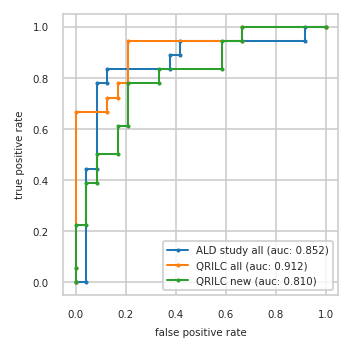

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       QRILC all       QRILC new      
             fpr   tpr       fpr   tpr       fpr   tpr
0          0.000 0.000     0.000 0.000     0.000 0.000
1          0.042 0.000     0.000 0.056     0.000 0.056
2          0.042 0.444     0.000 0.667     0.000 0.222
3          0.083 0.444     0.125 0.667     0.042 0.222
4          0.083 0.778     0.125 0.722     0.042 0.389
5          0.125 0.778     0.167 0.722     0.083 0.389
6          0.125 0.833     0.167 0.778     0.083 0.500
7          0.375 0.833     0.208 0.778     0.167 0.500
8          0.375 0.889     0.208 0.944     0.167 0.611
9          0.417 0.889     0.667 0.944     0.208 0.611
10         0.417 0.944     0.667 1.000     0.208 0.778
11         0.917 0.944     1.000 1.000     0.333 0.778
12         0.917 1.000       NaN   NaN     0.333 0.833
13         1.000 1.000       NaN   NaN     0.583 0.833
14           NaN   NaN       NaN   NaN     0.583 0.944
15           NaN   NaN       NaN   NaN     0.667 0.944
16           NaN   NaN       NaN   NaN     0.667 1.000
17           NaN   NaN       NaN   NaN     1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,QRILC all,QRILC new
rank,,,
0,P04075,P10636-2;P10636-6,D6R956;P09936
1,Q9NRN5,Q92542;Q92542-2,None
2,P09486,P01033;Q5H9A7,None
3,K7ERG9;P00746,P61981,None
4,P14174,P14174,None
5,P10636-2;P10636-6,Q9Y2T3;Q9Y2T3-3,None
6,P61981,P04075,None
7,Q6EMK4,P63104,None
8,Q9Y2T3;Q9Y2T3-3,P15151-2,None


### Precision-Recall plot on test data

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf


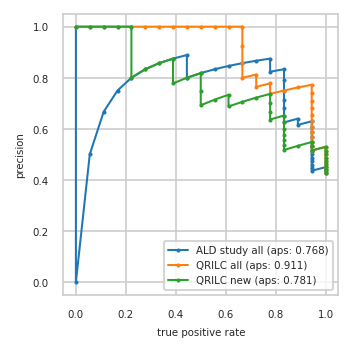

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all       QRILC all       QRILC new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.436 0.944     0.462 1.000     0.462 1.000
4          0.447 0.944     0.474 1.000     0.474 1.000
5          0.459 0.944     0.486 1.000     0.486 1.000
6          0.472 0.944     0.500 1.000     0.500 1.000
7          0.486 0.944     0.514 1.000     0.514 1.000
8          0.500 0.944     0.529 1.000     0.529 1.000
9          0.515 0.944     0.515 0.944     0.515 0.944
10         0.531 0.944     0.531 0.944     0.531 0.944
11         0.548 0.944     0.548 0.944     0.548 0.944
12         0.567 0.944     0.567 0.944     0.533 0.889
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.615 0.889     0.654 0.944     0.577 0.833
17         0.640 0.889     0.680 0.944     0.600 0.833
18         0.625 0.833     0.708 0.944     0.625 0.833
19         0.652 0.833     0.739 0.944     0.652 0.833
20         0.682 0.833     0.773 0.944     0.636 0.778
21         0.714 0.833     0.762 0.889     0.667 0.778
22         0.750 0.833     0.750 0.833     0.700 0.778
23         0.789 0.833     0.737 0.778     0.737 0.778
24         0.833 0.833     0.778 0.778     0.722 0.722
25         0.824 0.778     0.765 0.722     0.706 0.667
26         0.875 0.778     0.812 0.722     0.688 0.611
27         0.867 0.722     0.800 0.667     0.733 0.611
28         0.857 0.667     0.857 0.667     0.714 0.556
29         0.846 0.611     0.923 0.667     0.692 0.500
30         0.833 0.556     1.000 0.667     0.750 0.500
31         0.818 0.500     1.000 0.611     0.818 0.500
32         0.800 0.444     1.000 0.556     0.800 0.444
33         0.889 0.444     1.000 0.500     0.778 0.389
34         0.875 0.389     1.000 0.444     0.875 0.389
35         0.857 0.333     1.000 0.389     0.857 0.333
36         0.833 0.278     1.000 0.333     0.833 0.278
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     1.000 0.222
39         0.667 0.111     1.000 0.167     1.000 0.167
40         0.500 0.056     1.000 0.111     1.000 0.111
41         0.000 0.000     1.000 0.056     1.000 0.056
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf


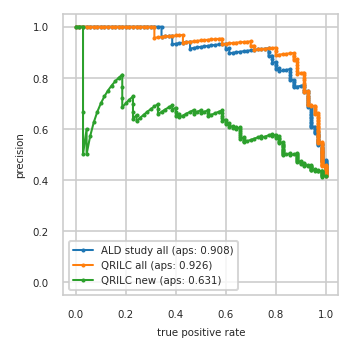

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

pimmslearn.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf


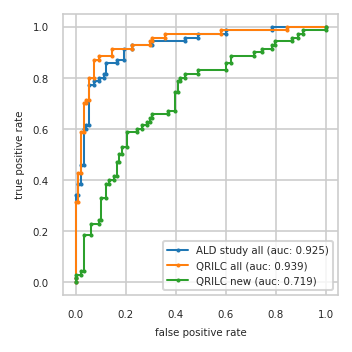

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
pimmslearn.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_QRILC all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC all.pkl'),
 'results_QRILC new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_QRILC new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_QRILC/auc_roc_curve_train.pdf')}